In [1]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import sys
import os 

# third party libraries
import matplotlib.pyplot as plt 
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func


In [2]:
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')),".."))
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SRC_DIR = os.path.join(REPO_ROOT,"src")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/FAUST10_pointnet.pt")

# repository modules
sys.path.insert(0, SRC_DIR)
import models
import train
import dataset
import utils

traindata = dataset.FaustDataset(FAUST, device=DEVICE, train=True, test=False, transform_data=True)
testdata = dataset.FaustDataset(FAUST, device=DEVICE, train=False, test=True,  transform_data=False)

In [44]:
from torch_geometric.data import DataLoader
t = DataLoader(traindata,
                batch_size=8,
                shuffle=True,
                num_workers=0)

In [46]:
from torch import nn
from models.pointnet import SimplePointNet 

LATENT_SPACE = 128

model = SimplePointNet(
    latent_dimensionality=LATENT_SPACE*2,
    convolutional_output_dim=512,
    conv_layer_sizes=[32, 128, 256],
    fc_layer_sizes=[512, 256, 128],
    transformer_positions=[0]).to(DEVICE)
print(model)

SimplePointNet(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (transformers): ModuleList(
    (0): SimpleTransformer(
      (conv_layers): ModuleList(
        (0): Sequential(
          (0): Conv1d(3, 64, kernel_size=(1,), stride=(1

In [45]:
#train network
train.train(
    train_data=t,#traindata.shuffle(),
    classifier=model,
    parameters_file=PARAMS_FILE,
    epoch_number=2, # <- change here the number of epochs used for training
    learning_rate=1e-3) 



  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1 of 2


ValueError: too many values to unpack (expected 2)

In [35]:
model.load_state_dict(torch.load(PARAMS_FILE, map_location=DEVICE))
model.eval()

SimplePointNet(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (transformers): ModuleList(
    (0): SimpleTransformer(
      (conv_layers): ModuleList(
        (0): Sequential(
          (0): Conv1d(3, 64, kernel_size=(1,), stride=(1

100%|██████████| 20/20 [00:01<00:00, 19.45it/s]

tensor(0.1000)


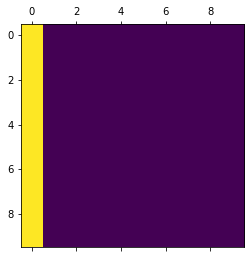

In [36]:
#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=testdata, classifier=model, epoch_number=1)

print(accuracy)
plt.matshow(confusion_matrix)
plt.show()